In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ---------------------------
# Feature Encoder
# ---------------------------
class FeatureEncoder(nn.Module):
    def __init__(self, temp_dim=100, pc_dim=7, param_dim=10, z_dim=128):
        super().__init__()
        self.temp_encoder = nn.Sequential(
            nn.Conv1d(1, 8, 5, padding=2), nn.ReLU(),
            nn.Conv1d(8, 16, 5, padding=2), nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.pc_encoder = nn.Sequential(
            nn.Linear(pc_dim, 64), nn.ReLU(),
            nn.Linear(64, 32)
        )
        self.param_encoder = nn.Sequential(
            nn.Linear(param_dim, 32), nn.ReLU()
        )
        self.final = nn.Sequential(
            nn.Linear(16 + 32 + 32, z_dim), nn.ReLU()
        )

    def forward(self, T_P, P_cloud, params):
        T_feat = self.temp_encoder(T_P.unsqueeze(1)).squeeze(-1)
        P_feat = self.pc_encoder(P_cloud).mean(dim=1)
        x_feat = self.param_encoder(params)
        z = self.final(torch.cat([T_feat, P_feat, x_feat], dim=-1))
        return z

# ---------------------------
# Thermal Surrogate Head
# ---------------------------
class ThermalHead(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(z_dim, 64), nn.ReLU(),
            nn.Linear(64, 2)  # [T_max, tau_melt]
        )

    def forward(self, z):
        out = self.fc(z)
        T_max, tau_melt = out[:, 0], out[:, 1]
        return T_max, tau_melt

# ---------------------------
# Defect Segmentation Head
# ---------------------------
class DefectSegmentationHead(nn.Module):
    def __init__(self, z_dim, pc_feat_dim=7, num_classes=4):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(pc_feat_dim + z_dim, 64), nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, P_cloud, z):
        B, N, D = P_cloud.shape
        z_exp = z.unsqueeze(1).repeat(1, N, 1)
        inputs = torch.cat([P_cloud, z_exp], dim=-1)
        logits = self.fc(inputs)
        return logits  # shape: [B, N, num_classes]

# ---------------------------
# Control Policy Head
# ---------------------------
class ControlPolicyHead(nn.Module):
    def __init__(self, z_dim, action_dim=3):
        super().__init__()
        self.policy = nn.Sequential(
            nn.Linear(z_dim, 64), nn.ReLU(),
            nn.Linear(64, action_dim)
        )

    def forward(self, z):
        return self.policy(z)

# ---------------------------
# Combined ATL Model
# ---------------------------
class ATLModel(nn.Module):
    def __init__(self, z_dim=128):
        super().__init__()
        self.encoder = FeatureEncoder(z_dim=z_dim)
        self.thermal_head = ThermalHead(z_dim)
        self.segmentation_head = DefectSegmentationHead(z_dim)
        self.policy_head = ControlPolicyHead(z_dim)

    def forward(self, T_P, P_cloud, params):
        z = self.encoder(T_P, P_cloud, params)
        T_max, tau_melt = self.thermal_head(z)
        seg_logits = self.segmentation_head(P_cloud, z)
        control = self.policy_head(z)
        return T_max, tau_melt, seg_logits, control

# ---------------------------
# Example Inference Function
# ---------------------------
def run_inference(model, T_P, P_cloud, params):
    model.eval()
    with torch.no_grad():
        T_max, tau_melt, seg_logits, control = model(T_P, P_cloud, params)
        p_defects = F.softmax(seg_logits, dim=-1)
        return {
            'T_max': T_max,
            'tau_melt': tau_melt,
            'defect_probs': p_defects,
            'control_action': control
        }

# ---------------------------
# Utility: Total Variation Loss
# ---------------------------
def total_variation_loss(p):
    tv = torch.sum(torch.abs(p[:, 1:, :] - p[:, :-1, :]))
    return tv

# ---------------------------
# Example Loss Function
# ---------------------------
def compute_losses(preds, targets, weights, lambdas):
    T_max, tau_melt, seg_logits, _ = preds
    T_max_true, tau_melt_true = targets['thermal']
    y_true = targets['seg_labels']
    w = weights

    L_thermal = F.mse_loss(T_max, T_max_true) + F.mse_loss(tau_melt, tau_melt_true)
    L_seg = F.cross_entropy(seg_logits.view(-1, seg_logits.shape[-1]), y_true.view(-1), weight=w) + \
            lambdas['tv'] * total_variation_loss(F.softmax(seg_logits, dim=-1))
    # Dummy RL loss
    L_RL = torch.tensor(0.0, requires_grad=True)

    total_loss = lambdas['thermal'] * L_thermal + lambdas['seg'] * L_seg + lambdas['RL'] * L_RL
    return total_loss


In [2]:
# Dummy input sizes: (batch_size=4)
T_P = torch.randn(4, 100)                  # Temperature sequence
P_cloud = torch.randn(4, 1024, 7)          # Point cloud features
params = torch.randn(4, 10)                # Process parameters

model = ATLModel()
outputs = run_inference(model, T_P, P_cloud, params)

print(outputs['T_max'])
print(outputs['control_action'])


tensor([0.0987, 0.1372, 0.1641, 0.1502])
tensor([[ 0.0742, -0.1118,  0.1256],
        [ 0.0668, -0.1163,  0.1566],
        [ 0.0984, -0.1189,  0.1542],
        [ 0.0931, -0.1180,  0.1524]])


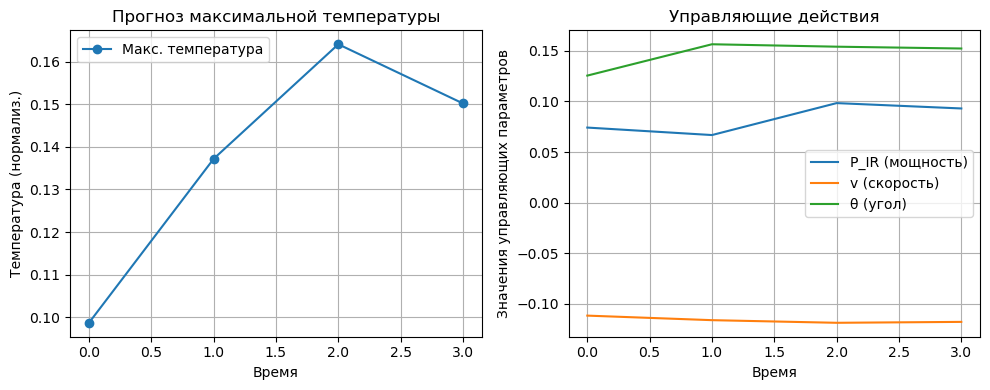

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Пример данных (эти можно заменить на реальные из вашей модели)
time_steps = np.arange(0, 4)  # 4 временных шага

# Пример температурных прогнозов
temperature_preds = np.array([0.0987, 0.1372, 0.1641, 0.1502])

# Пример управляющих действий: [P_IR, v, theta] для каждого шага
control_actions = np.array([
    [0.0742, -0.1118, 0.1256],
    [0.0668, -0.1163, 0.1566],
    [0.0984, -0.1189, 0.1542],
    [0.0931, -0.1180, 0.1524]
])

# График температуры
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(time_steps, temperature_preds, marker='o', label='Макс. температура')
plt.xlabel('Время')
plt.ylabel('Температура (нормализ.)')
plt.title('Прогноз максимальной температуры')
plt.legend()
plt.grid(True)

# График управляющих действий
plt.subplot(1,2,2)
plt.plot(time_steps, control_actions[:,0], label='P_IR (мощность)')
plt.plot(time_steps, control_actions[:,1], label='v (скорость)')
plt.plot(time_steps, control_actions[:,2], label='θ (угол)')
plt.xlabel('Время')
plt.ylabel('Значения управляющих параметров')
plt.title('Управляющие действия')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


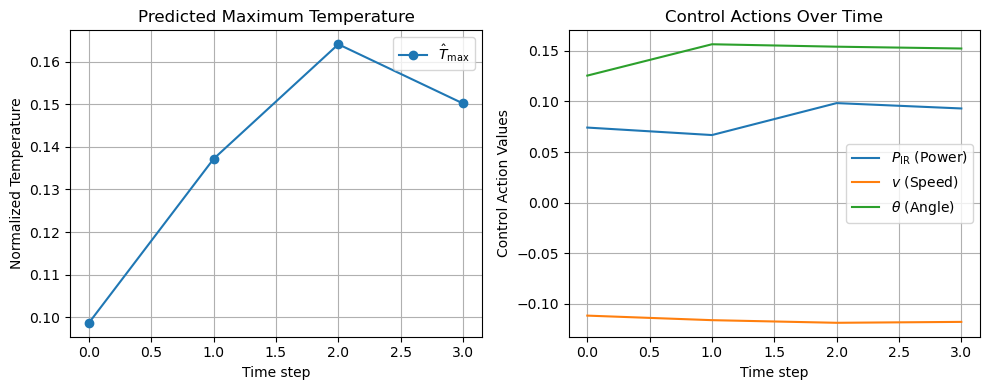

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace with your model outputs)
time_steps = np.arange(0, 4)  # 4 time steps

# Predicted maximum temperatures \hat{T}_{\max}
temperature_preds = np.array([0.0987, 0.1372, 0.1641, 0.1502])

# Control actions for each time step: [P_IR, v, θ]
control_actions = np.array([
    [0.0742, -0.1118, 0.1256],
    [0.0668, -0.1163, 0.1566],
    [0.0984, -0.1189, 0.1542],
    [0.0931, -0.1180, 0.1524]
])

# Plot maximum temperature over time
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(time_steps, temperature_preds, marker='o', label=r'$\hat{T}_{\max}$')
plt.xlabel('Time step')
plt.ylabel('Normalized Temperature')
plt.title('Predicted Maximum Temperature')
plt.legend()
plt.grid(True)

# Plot control actions over time
plt.subplot(1,2,2)
plt.plot(time_steps, control_actions[:,0], label=r'$P_{\mathrm{IR}}$ (Power)')
plt.plot(time_steps, control_actions[:,1], label=r'$v$ (Speed)')
plt.plot(time_steps, control_actions[:,2], label=r'$\theta$ (Angle)')
plt.xlabel('Time step')
plt.ylabel('Control Action Values')
plt.title('Control Actions Over Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("plots.pdf")
plt.show()
